# Day 06: Red

For this category, I wanted to begin to explore PyGMT. The color red also reminds me of high temperatures... so I'll be looking into temperature anomaly data from Berkeley Earth!

There are a variety of data sources I will use throughout these exercises, including:
* [Explorer Basemap](https://visibleearth.nasa.gov/images/147190/explorer-base-map): Joshua Stevens, NASA Earth Observatory
* [Comprehensive Global Administrative Zones (CGAZ)](https://www.geoboundaries.org/): geoBoundaries 4.0, William & Mary geoLab
* [Marine polys and lakes](https://www.naturalearthdata.com/): Natural Earth
* [World Cities](https://simplemaps.com/data/world-cities): Simple Maps

Data sources specific to a single day will be linked in the notebook where they appear.

## Configuration

In [1]:
import os
import xarray as xr
import pygmt
import numpy as np
from matplotlib import cm
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
# Choose bounding box of interest

# USA
lats = [0, 50]
lons = [-130, -50]

# EUR
# lats = [20, 60]
# lons = [-20, 50]

# AUS
# lats = [-50, 0]
# lons = [90, 170]

# Choose year of interest
year = 2010

# Temperature anomaly data
Gridded data from [Berkeley Earth](http://berkeleyearth.org/data/) regardly monthly average temperature anomaly on land is used in this example.


In [3]:
# Map to path
data_file = "Complete_TAVG_LatLong1.nc"
data_folder = os.path.join("..", "data", "etc", "berkeley-earth")
data_path = os.path.join(data_folder, data_file)

# Read data
data = xr.open_dataset(data_path)

# Preview
data

<xarray.Dataset>
Dimensions:      (latitude: 180, longitude: 360, month_number: 12, time: 3261)
Coordinates:
  * longitude    (longitude) float32 -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
  * latitude     (latitude) float32 -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
  * time         (time) float64 1.75e+03 1.75e+03 ... 2.022e+03 2.022e+03
Dimensions without coordinates: month_number
Data variables:
    land_mask    (latitude, longitude) float64 ...
    temperature  (time, latitude, longitude) float32 ...
    climatology  (month_number, latitude, longitude) float32 ...
Attributes:
    Conventions:          Berkeley Earth Internal Convention (based on CF-1.5)
    title:                Gridded Berkeley Earth Surface Temperature Anomaly ...
    history:              06-Oct-2021 21:11:47
    institution:          Berkeley Earth Surface Temperature Project
    source_file:          Complete_TAVG.50592s.20211006T205528.mat
    source_history:       03-Oct-2021 08:32:25
    source_code_version:  eead777c589734c11a431a21725e06d3
    comment:              This file contains surface temperature anomaly fiel...

In [4]:
# Get recent average
recent = data.sel(
    latitude=slice(lats[0], lats[1]),
    longitude=slice(lons[0], lons[1]),
    time=slice(year,year+1)
)

# Calculate standard mean
recent_mean = recent.mean(dim=['time'], skipna=True)

# Convert to dataframe
df = recent_mean.to_dataframe().reset_index()

# Drop NaN values
df = df[df['temperature'].notna()]

# Preview
print(f"Temperature anomaly ranges between {df.temperature.min()} and {df.temperature.max()}")
df.head(5)

Temperature anomaly ranges between -0.6260860562324524 and 3.1754226684570312


,latitude,longitude,month_number,land_mask,temperature,climatology
588,0.5,-80.5,0,0.06,0.463366,21.985867
589,0.5,-80.5,1,0.06,0.463366,22.218716
590,0.5,-80.5,2,0.06,0.463366,22.899500
591,0.5,-80.5,3,0.06,0.463366,23.267832
592,0.5,-80.5,4,0.06,0.463366,23.003347


# Create map using PyGMT

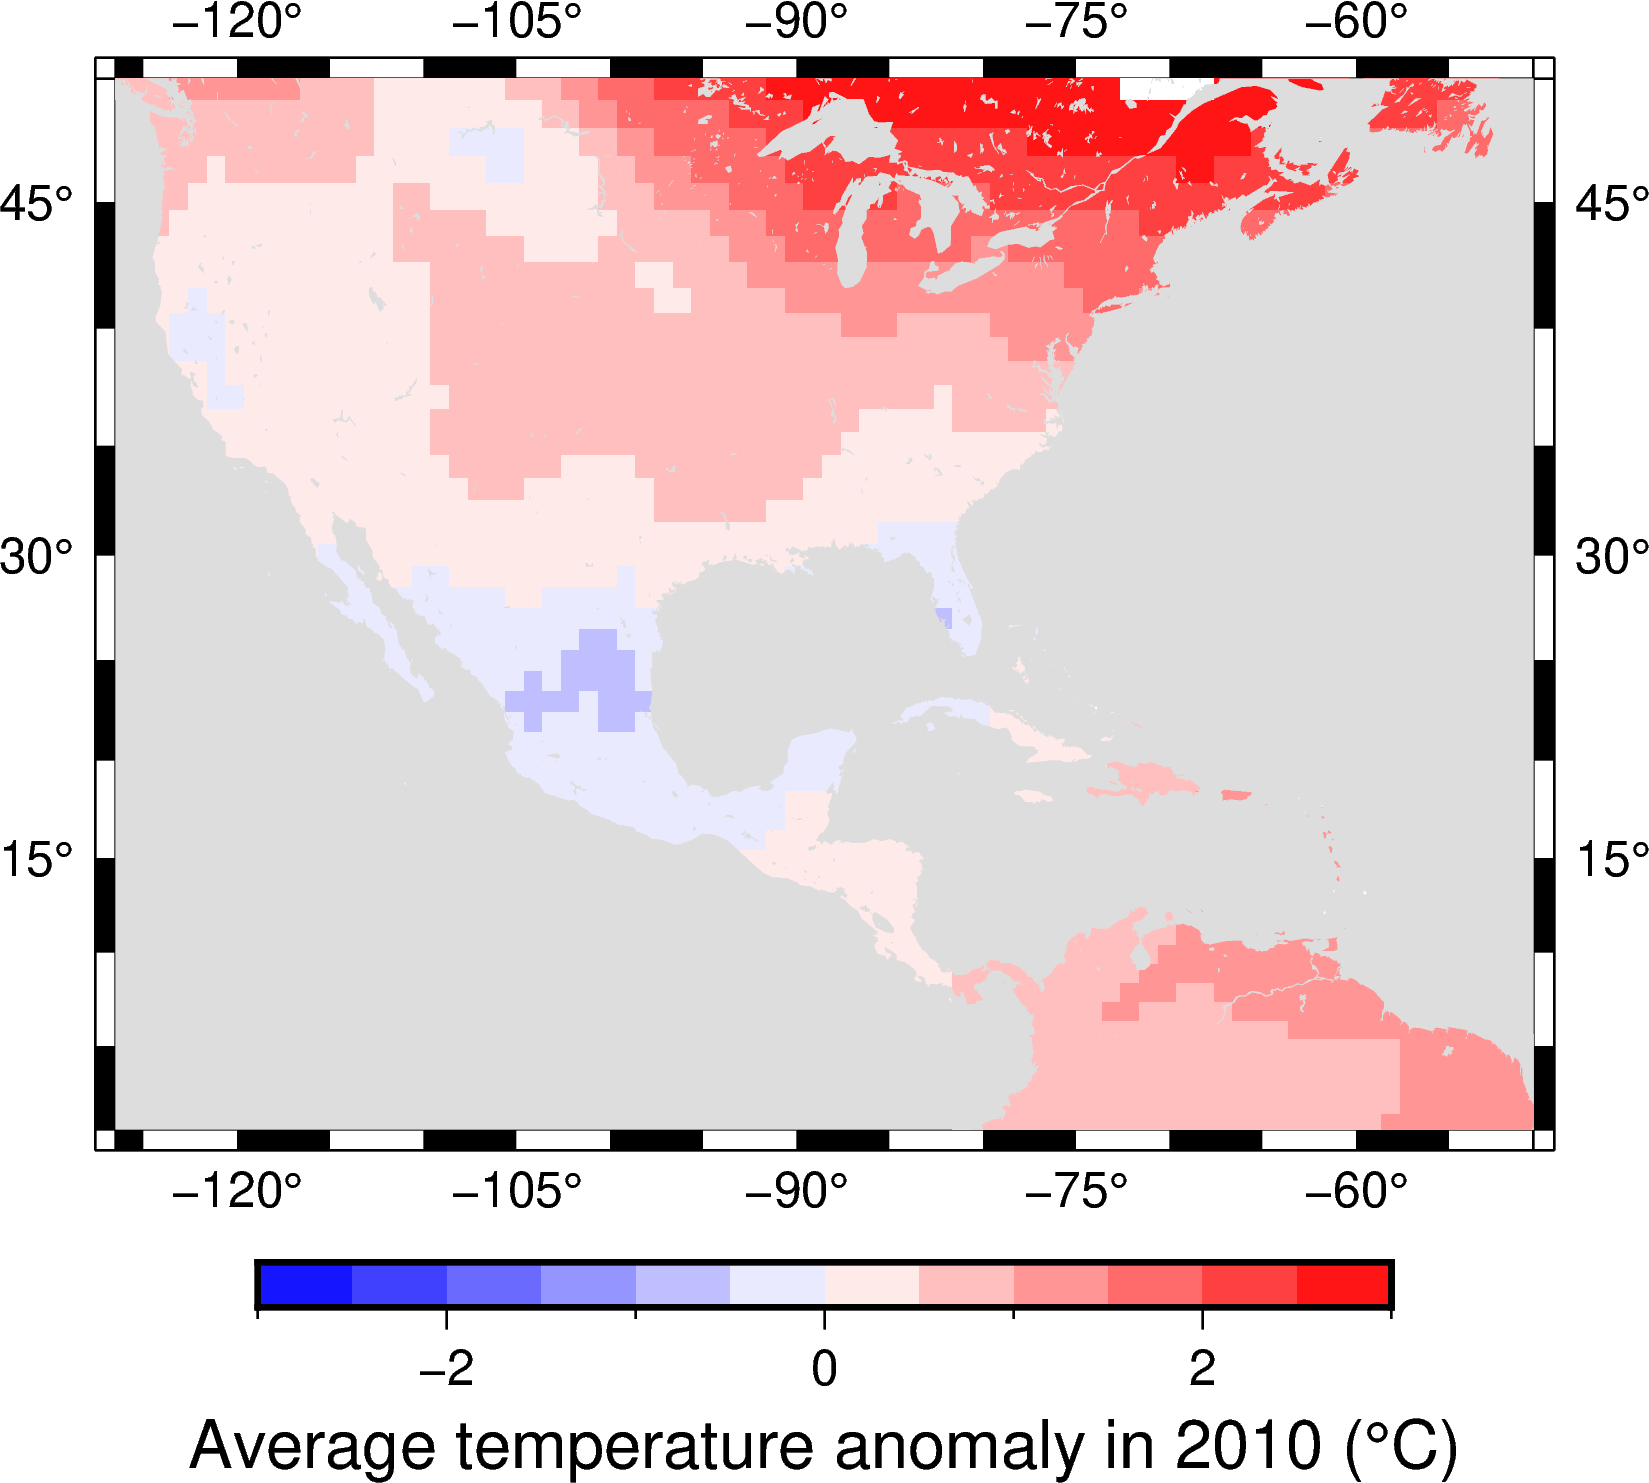

In [5]:
# Set the region for the plot based on the data
region = [
    df.longitude.min(),
    df.longitude.max(),
    df.latitude.min(),
    df.latitude.max(),
]

# Choose colormap
cmap = "polar"

# Construct figure
fig = pygmt.Figure()
fig.basemap(region=region, projection="M0/0/12c", frame=True) 
# Set colormap
pygmt.makecpt(cmap=cmap, series=(-3, 3, 0.5))
fig.colorbar(frame=f'af+l"Average temperature anomaly in {year} (@.C)"')
# Data
fig.plot(
    x=df.longitude,
    y=df.latitude,
    color=df.temperature,
    cmap=True,
    style="s0.5c",
)
# Add water
fig.coast(water="#dddddd")

# Save figure
out_folder = os.path.join("..", "contributions")
out_file = f"06_{year}.png"
out_path = os.path.join(out_folder, out_file)
fig.savefig(out_path, dpi=300)

# Preview
fig.show()